In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import nest
nest.Install('scmodule')
nest.SetKernelStatus({"resolution": 0.01})

In [2]:
num_neurons = 200
num_deg = 20
sigma = 8.0 #ms amplitud de la kernel gaussiana
min_tau = 10.0 #constante de tiempo de adaptación mínima
max_tau = 80.0 #constante de tiempo de adaptación máxima
wexc_factor = 0.160 #nS Factor de excitación
winh_factor = 0.05 #nS Factor de inhibición
syn_exc = 0.4 #mm rango de sinápsis excitatorias
syn_inh = 1.2 #mm rango de sinápsis inhibitorias
max_pos = 5.0 #mm posición anatómica máxima
min_pos = 0.0 #mm posición anatómica mínima
#Logarithmic mapping function
Bu = 1.4 #mm
A = 3 #deg
min_sacc_amp = 3
max_sacc_amp = 63
simulation_len = 300.0

In [3]:
position = numpy.linspace(min_pos, max_pos, num_neurons)
r = numpy.linspace(min_sacc_amp, max_sacc_amp, num_deg) #amplitudes del sacádico
ut=Bu*numpy.log((r+A)/A) #posición del sacádico en función de la amplitud
distance = numpy.zeros((len(position),len(ut)))
#matriz de distancias entre la posición central de sacádico y la posición de la neurona
for idx_p,pos in enumerate(position):
    for idx_s,site in enumerate(ut):
        distance[idx_p,idx_s] = numpy.absolute(pos-site)  
id_min_dis = numpy.argmin(distance, axis=0) #neurona central
print id_min_dis

[ 39  62  79  91 102 110 118 125 131 136 141 145 150 153 157 160 164 167
 170 172]


In [4]:
sacc_3 = distance[:,0]
GEN_list = []
for dist_3 in sacc_3:
    GEN_list.append({"i0":3.0, "beta":0.03, "gamma":1.8, "pop":0.5, "sc_onset":0.0, "distance":dist_3})
GEN_pop = nest.Create("sc_generator", num_neurons, params=GEN_list)

In [5]:
FEF_dict = {"C_m":50.0,"t_ref":0.0,"V_reset":-55.0,"E_L":-70.0, "g_L":2.0, "I_e":0.0, "a":0.0, "b":60.0, 
            "Delta_T":2.0, "tau_w":30.0, "V_th":-50.0, "V_peak":-30.0}
FEF_pop = nest.Create("aeif_cond_exp", num_neurons, params=FEF_dict)

In [6]:
tau_net = numpy.linspace(max_tau, min_tau, num_neurons)
SC_list = []
for tau_w in tau_net:
    SC_list.append({"C_m":280.0,"t_ref":0.0, "V_reset":-45.0, "E_L":-70.0, "g_L":10.0,"I_e":0.0, "a":4.0,
                    "b":80.0, "Delta_T":2.0,"V_th":-50.0, "V_peak":-30.0,"E_ex":0.0, "tau_syn_ex":5.0,
                    "E_in":-80.0, "tau_syn_in":10.0, "tau_w":tau_w})  
SC_pop = nest.Create("aeif_cond_exp",num_neurons, params=SC_list)

In [7]:
#Lateral intracollicular connections
position = numpy.linspace(min_pos, max_pos, num_neurons)

wexc = numpy.zeros((num_neurons*num_neurons))
sc_filas = numpy.repeat(range(num_neurons), num_neurons)
sc_colum = numpy.tile(range(num_neurons), num_neurons)
wexc = wexc_factor*numpy.exp(-(numpy.square(position[sc_filas]-position[sc_colum]))
                             /(2*numpy.square(syn_exc)))        
wexc = wexc.reshape((num_neurons,num_neurons))
numpy.fill_diagonal(wexc,0)

wind = numpy.zeros((num_neurons*num_neurons))
ind_filas = numpy.repeat(range(num_neurons), num_neurons)
ind_colum = numpy.tile(range(num_neurons), num_neurons)
winh = winh_factor*numpy.exp(-(numpy.square(position[ind_filas]-position[ind_colum]))
                             /(2*numpy.square(syn_inh)))        
winh = winh.reshape((num_neurons,num_neurons))
numpy.fill_diagonal(winh,0)

conn_dict = {'rule':'all_to_all', 'autapses': True}

syn_dict_exc = {'weight': wexc, 'delay':1.0}
nest.Connect(SC_pop, SC_pop, conn_spec = conn_dict, syn_spec = syn_dict_exc)

syn_dict_inh = {'weight': -winh, 'delay':1.0}
nest.Connect(SC_pop, SC_pop,  conn_spec = conn_dict, syn_spec = syn_dict_inh)


In [8]:
def funcion_polinomio(tau_net):
    return ((-0.001803*tau_net*tau_net) + (0.2925*tau_net) + 3.432)
wei_net = funcion_polinomio(tau_net)

In [9]:
nest.Connect(GEN_pop, FEF_pop, "one_to_one", syn_spec={'weight':1.0, 'delay':1.0})
syn_dict = {'weight': wei_net, 'delay':1.0}
nest.Connect(FEF_pop, SC_pop, "one_to_one",  syn_spec=syn_dict)

In [10]:
spikedetector = nest.Create("spike_detector", params={"withgid":True, "withtime":True})
nest.Connect(SC_pop, spikedetector, syn_spec={'delay':1.0})

In [11]:
for idx_sacc in range(0, len(r)):
    dicts = [{'distance':value,"sc_onset":idx_sacc*simulation_len} for value in distance[:,idx_sacc]]
    nest.SetStatus(GEN_pop, dicts)
    nest.Simulate(simulation_len) 

In [12]:
dSD = nest.GetStatus(spikedetector)[0]
evs = dSD["events"]["senders"]
tspk = dSD["events"]["times"]


Número de spikes.

In [13]:
num_spikes = numpy.zeros(len(r))
for id_sacc in range(0, len(r)):
    tini = id_sacc*simulation_len
    tend = tini+simulation_len
    sel_spk = numpy.logical_and(tspk>tini, tspk<tend)
    idx_central = id_min_dis[id_sacc]
    neu_central = SC_pop[idx_central]
    spk_central = numpy.logical_and(evs==neu_central, sel_spk)
    num_spikes[id_sacc] = numpy.count_nonzero(spk_central)

In [14]:
def gaussian_funct(time_diff, sigma):
    return (1/(sigma*numpy.sqrt(2*numpy.pi))*numpy.exp(-(time_diff*time_diff)/(2*(sigma*sigma))))

t = numpy.arange(-30.0, 80.0, 0.1)
maximo = numpy.zeros(len(r))
    
for id_sacc in range(0, len(r)):
    tini = id_sacc*simulation_len
    tend = tini+simulation_len
    sel_spk = numpy.logical_and(tspk>tini, tspk<tend)
    idx_central = id_min_dis[id_sacc]
    neu_central = SC_pop[idx_central]
    spk_central = numpy.logical_and(evs==neu_central, sel_spk)
    first_spk = numpy.min(tspk[spk_central])
    gauss = numpy.zeros((t.shape[0]))
    for spike in tspk[spk_central]:
        time_diff = t-(spike-first_spk)
        gauss[:] = gauss[:]+(gaussian_funct(time_diff, sigma))
    gauss = gauss*1e3
    maximo[id_sacc]=numpy.max(gauss)
    
print maximo

[ 702.61488969  683.60979357  670.76425524  655.65596581  643.67226465
  630.2328812   617.7537196   613.95581292  599.95767797  590.53965555
  585.05370614  578.21031887  562.97289662  559.1462295   553.6880406
  545.44871713  534.49575012  530.85072767  520.28301019  517.57216603]


<IPython.core.display.Javascript object>


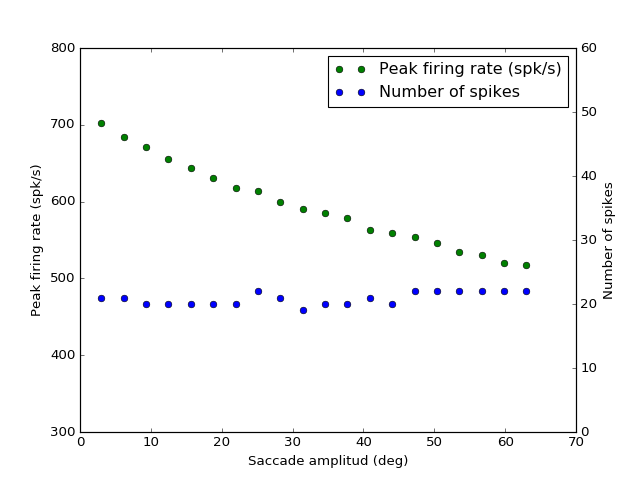

In [15]:
fig, ax1 = plt.subplots()
line1 = ax1.plot(r, maximo, label='Peak firing rate (spk/s)', color='g', marker='o', linewidth= 0.0)
ax1.set_xlabel('Saccade amplitud (deg)')
ax1.set_ylabel('Peak firing rate (spk/s)')
ax2 = ax1.twinx()
line2 = ax2.plot(r, num_spikes, label='Number of spikes', color='b', marker='o', linewidth= 0.0)
ax2.set_ylabel('Number of spikes')
ax1.set_ylim([300.0,800.0])
ax2.set_ylim([0.0, 60.0])
lns = line1+line2
label = [l.get_label() for l in lns]
ax1.legend(lns, label, loc=0)

Fig. 17. Tasa máxima de disparo y número de spikes de la neurona central en función de
la amplitud del sacádico.